<h1 style=color:"#0EA293";padding-left:130px;>Install All These Dependencies </h1> 

<p style=color:#1BB555>!pip install tensorflow</p>
<p style=color:#1BB555>!pip install keras</p>
<p style=color:#1BB555>!pip install opencv-python</p>
<p style=color:#1BB555>!pip install matplotlib</p>
<p style=color:#1BB555>!pip install numpy</p>


In [2]:
!pip install tensorflow
!pip install keras
!pip install opencv-python
!pip install numpy
!pip install matplotlib

     ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
     ---------------------------------------- 0.1/7.6 MB 1.9 MB/s eta 0:00:04
      --------------------------------------- 0.1/7.6 MB 1.1 MB/s eta 0:00:07
     - -------------------------------------- 0.2/7.6 MB 1.3 MB/s eta 0:00:06
     - -------------------------------------- 0.3/7.6 MB 1.5 MB/s eta 0:00:05
     - -------------------------------------- 0.3/7.6 MB 1.5 MB/s eta 0:00:05
     - -------------------------------------- 0.3/7.6 MB 999.9 kB/s eta 0:00:08
     - -------------------------------------- 0.3/7.6 MB 999.9 kB/s eta 0:00:08
     - -------------------------------------- 0.4/7.6 MB 849.3 kB/s eta 0:00:09
     -- ------------------------------------- 0.4/7.6 MB 781.2 kB/s eta 0:00:10
     -- ------------------------------------- 0.4/7.6 MB 778.2 kB/s eta 0:00:10
     -- ------------------------------------- 0.4/7.6 MB 689.6 kB/s eta 0:00:11
     -- ------------------------------------- 0.5/7.6 MB 67


<h1 style=color:#0EA293;padding-left:80px;font-size:20px;>Import all the Dependencies</h1> 

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

<h1 style=color:#0EA293;padding-left:80px;font-size:20px;>Set all the Constants</h1> 

In [48]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20


<h1 style=color:#0EA293;padding-left:80px;font-size:20px;>Import data into tensorflow dataset object</h1> 


<p style=color:#1BB555>We will use image_dataset_from_directory api to load all images in tensorflow dataset:</p>

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "covid_dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3219 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['COVID_ NEGATIVE', 'COVID_POSSITIVE']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1]




<p style=color:#1BB555>As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels</p>


<h1 style=color:#0EA293;padding-left:80px;font-size:20px;>Visualize some of the images from our dataset:</h1> 

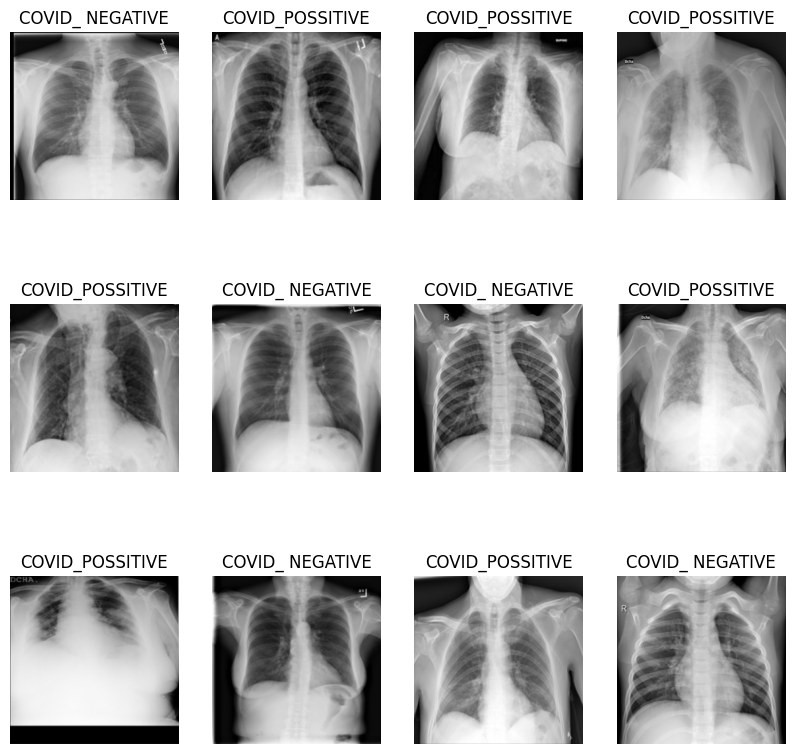

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")



<h1 style=color:#0EA293;padding-left:80px;font-size:20px;>Function to Split Dataset</h1> 

<p style=color:#1BB555>Dataset should be bifurcated into 3 subsets, namely:</p>

1. <p style=color:#1BB555> Training: Dataset to be used while training:</p>
2. <p style=color:#1BB555>Validation: Dataset to be tested against while training:</p>
3. <p style=color:#1BB555>Test: Dataset to be tested against after we trained a model:</p>


In [7]:
len(dataset)

101

In [8]:
train_size = 0.8
len(dataset)*train_size

80.80000000000001

In [9]:
train_ds = dataset.take(80)
len(train_ds)

80

In [10]:
test_ds = dataset.skip(80)
len(test_ds)

21

In [11]:
val_size=0.1
len(dataset)*val_size

10.100000000000001

In [12]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [13]:
test_ds = test_ds.skip(10)
len(test_ds)

11


<h1 style=color:#0EA293;padding-left:80px;font-size:20px;>function to split data into train,test and validation </h1> 


In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

80

In [17]:
len(val_ds)

10

In [18]:
len(test_ds)

11



<h1 style=color:#0EA293;padding-left:80px;font-size:20px;>Cache, Shuffle, and Prefetch the Dataset </h1> 


In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


<h1 style=color:#0EA293;padding-left:80px;font-size:30px;>Building the Model</h1> 


<h1 style=color:#0EA293;font-size:20px;>Creating a Layer for Resizing and Normalization</h1>
<hr>
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


<h1 style=color:#0EA293;padding-left:80px;font-size:30px;>Data Augmentation</h1> 

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


<h1 style=color:#0EA293;font-size:20px;>Applying Data Augmentation to Train Dataset</h1>


In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN**


In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         


<h1 style=color:#0EA293;font-size:20px;> Compiling the Model</h1>

We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
80/80 [==============================] - 335s 4s/step - loss: 0.5472 - accuracy: 0.7091 - val_loss: 0.2998 - val_accuracy: 0.8906
Epoch 2/20
80/80 [==============================] - 313s 4s/step - loss: 0.2921 - accuracy: 0.8979 - val_loss: 0.3113 - val_accuracy: 0.9000
Epoch 3/20
80/80 [==============================] - 308s 4s/step - loss: 0.2807 - accuracy: 0.9046 - val_loss: 0.2275 - val_accuracy: 0.9156
Epoch 4/20
80/80 [==============================] - 307s 4s/step - loss: 0.2405 - accuracy: 0.9124 - val_loss: 0.2425 - val_accuracy: 0.8969
Epoch 5/20
80/80 [==============================] - 305s 4s/step - loss: 0.2181 - accuracy: 0.9230 - val_loss: 0.2084 - val_accuracy: 0.9312
Epoch 6/20
80/80 [==============================] - 303s 4s/step - loss: 0.2221 - accuracy: 0.9207 - val_loss: 0.2057 - val_accuracy: 0.9375
Epoch 7/20
80/80 [==============================] - 301s 4s/step - loss: 0.2157 - accuracy: 0.9187 - val_loss: 0.2193 - val_accuracy: 0.9344
Epoch 8/20
80

  
<h1 style=color:#0EA293;font-size:20px;>Saving the Model</h1>


In [38]:
model.save('COVIDR.h5')

In [39]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 11s 1s/step - loss: 0.1599 - accuracy: 0.9375


**You can see above that we get `93.75%` accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [49]:
scores

[0.15994738042354584, 0.9375]

**Scores is just a list containing loss and accuracy value:**


<h1 style=color:#0EA293;font-size:20px;>Plotting the Accuracy and Loss Curves</h1>


In [50]:
history

**You can read documentation on history object here:** 
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [51]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 80}

In [52]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [53]:
type(history.history['loss'])

list

In [54]:
len(history.history['loss'])

20

In [55]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.5471969842910767,
 0.29209327697753906,
 0.28072792291641235,
 0.24051004648208618,
 0.21814456582069397]

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

<h1 style=color:#0EA293;font-size:20px;>Training  accuracy  vs Epcohs , validation accuracy vs Epochs , Training and validation loss vs Epochs</h1>


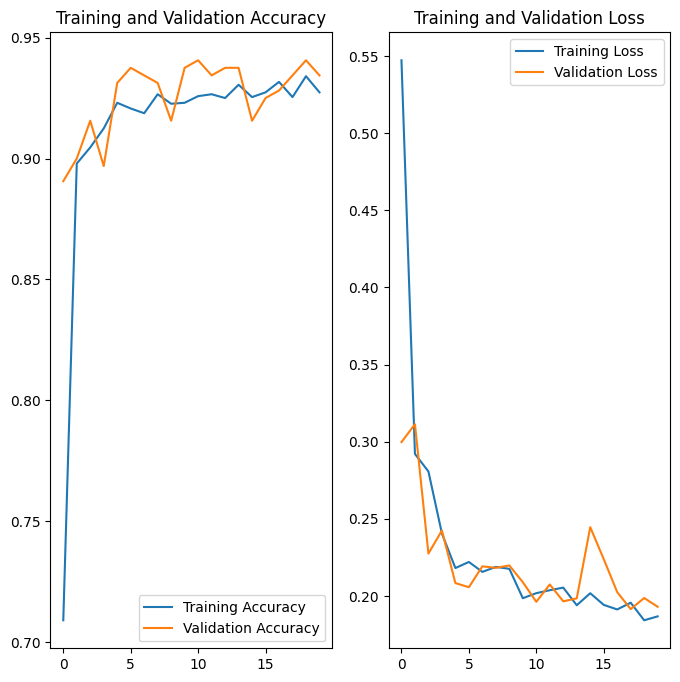

In [57]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


<h1 style=color:#0EA293;font-size:20px;>Run prediction on a sample image</h1>


first image to predict
actual label: COVID_POSSITIVE
1/1 [==============================] - 2s 2s/step
predicted label: COVID_POSSITIVE


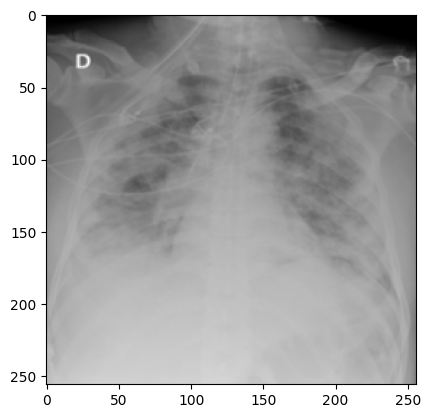

In [58]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

<h1 style=color:#0EA293;font-size:20px;>Write a function for inference</h1>

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


<h1 style=color:#0EA293;font-size:20px;>Now run inference on few sample images</h1>

1/1 [==============================] - 0s 90ms/step


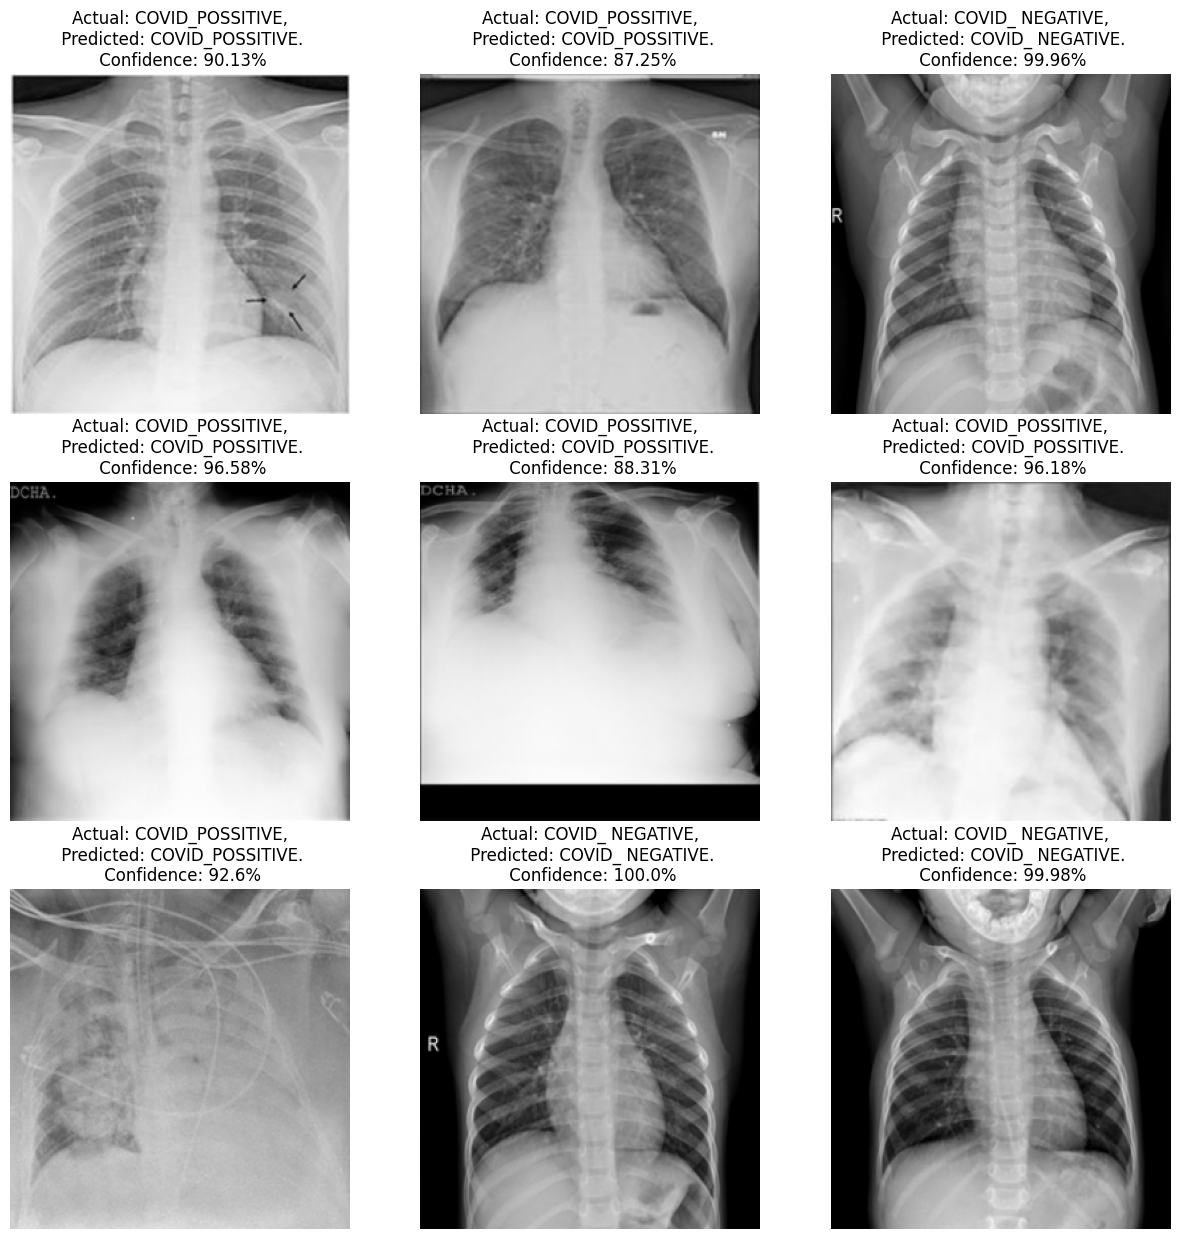

In [61]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


<h1 style=color:#0EA293;font-size:20px;>Load the saved Model</h1>

In [62]:
from tensorflow.keras.models import load_model

In [63]:
face_model = load_model('COVIDR.h5')

**Detect the face** 

In [64]:
import cv2
from tensorflow.keras.preprocessing import image 

import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

In [65]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 97ms/step


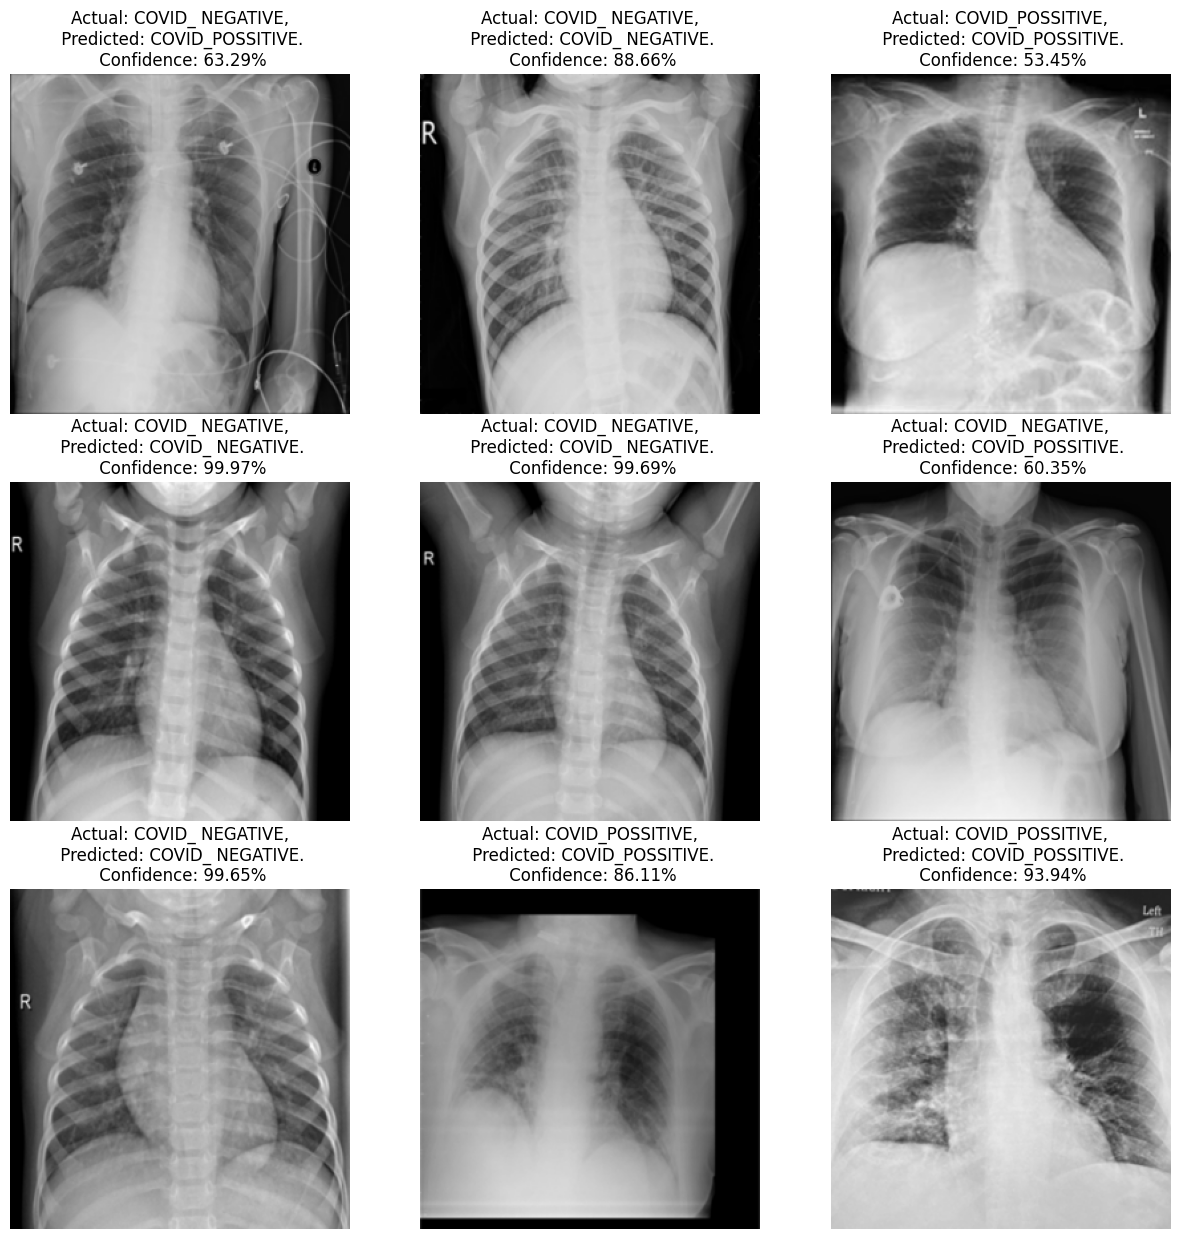

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(face_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [69]:
from tensorflow.keras.preprocessing import image

In [70]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    print("predictions:",predictions)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
def predict(img):
    image = np.array(img)
    image  = image
  
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    print("predictions:",predictions)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [71]:
img_path = 'Normal-1.PNG'

In [72]:
image = image.load_img(img_path, target_size=(256,256))


In [73]:
 predicted_class, confidence =predict(face_model, image)


1/1 [==============================] - 0s 85ms/step
predictions: [[0.9532758  0.04672415]]


Text(0.5, 1.0, '95.33%')

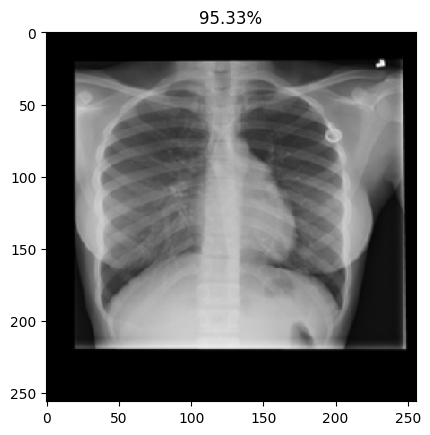

In [74]:
plt.imshow(image)
plt.title(predicted_class)
plt.title("\n")
plt.title(str(confidence) +"%")

In [76]:
pip install gradio

     ---------------------------------------- 0.0/17.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/17.3 MB ? eta -:--:--
     --------------------------------------- 0.0/17.3 MB 330.3 kB/s eta 0:00:53
     --------------------------------------- 0.0/17.3 MB 330.3 kB/s eta 0:00:53
     --------------------------------------- 0.0/17.3 MB 330.3 kB/s eta 0:00:53
     --------------------------------------- 0.1/17.3 MB 172.4 kB/s eta 0:01:41
     --------------------------------------- 0.1/17.3 MB 178.6 kB/s eta 0:01:37
     --------------------------------------- 0.1/17.3 MB 210.1 kB/s eta 0:01:22
     --------------------------------------- 0.1/17.3 MB 210.1 kB/s eta 0:01:22
     --------------------------------------- 0.1/17.3 MB 192.8 kB/s eta 0:01:30
     --------------------------------------- 0.1/17.3 MB 200.4 kB/s eta 0:01:26
     --------------------------------------- 0.2/17.3 MB 218.5 kB/s eta 0:01:19
      -------------------------------------- 0.2/17.3 MB

In [75]:
predicted_class

'COVID_ NEGATIVE'

In [ ]:
import cv2
import numpy as np
